In [1]:
!pip install hypertools

In [3]:
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../'))
from timecorr.timecorr import levelup, decode
import matplotlib.pyplot as plt
from math import log
from random import shuffle
import scipy.spatial.distance as sd

sliding_window_length = 51
block_length = 1
covariance_num = 300
noise_level = [0,0.01,0.1,1,10]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
level_num = 11
subject_num = 6
activation_num = 5

# activations = [[np.random.normal(0,1,[activation_num, time_len]) for i in range(subject_num)] for j in range(noise_num)]
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
all_activations = np.zeros([(level_num-1),repetitions,noise_num,subject_num, time_len,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
#     global activations, correlations,correlation1,correlation2
    correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    activations = [[np.random.normal(0,1,[activation_num, time_len]) for i in range(subject_num)] for j in range(noise_num)]

    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=np.array([(activations_temp+np.random.normal(0,noise_level[i],[activation_num, time_len])).T for s in range(subject_num)])
    return activations


def decoding_raw_data(data,nfolds):
    subj_num=len(data)
    subj_indices = range(subj_num)
    accuracy = 0
    for i in range(nfolds):
        shuffle(subj_indices)
        in_fold_corrs = np.mean(data[subj_indices[:(subj_num/2)]],0)
        out_fold_corrs = np.mean(data[subj_indices[(subj_num/2):]],0)
        corrs = 1 - sd.cdist(in_fold_corrs, out_fold_corrs, 'correlation')
        accuracy_temp = 0

        #timepoint_dists = la.toeplitz(np.arange(corrs.shape[0]))
        for t in range(0, corrs.shape[0]):
            include_inds = np.arange(corrs.shape[0])
            decoded_inds = include_inds[np.where(corrs[t, include_inds] == np.max(corrs[t, include_inds]))]
            accuracy_temp += np.mean(decoded_inds == np.array(t))
        accuracy_temp /= corrs.shape[0]
        accuracy += accuracy_temp
    accuracy /= nfolds
    return accuracy

all_activations[0] = np.load("../levelup_data.npy")
decoding_accuracy = np.zeros([noise_num, level_num])
for i in range(repetitions):
#     for n in range(noise_num):
#         decoding_accuracy[n,0] += decoding_raw_data(all_activations[i,n],nfolds=3)
    for l in range(1,level_num):
        for n in range(noise_num):
            if l>1:
                all_activations[(l-1),i,n] = levelup(all_activations[(l-2),i,n],mode="within")
            if l==level_num-1:
                results = decode(all_activations[(l-1),i,n],nfolds=3, var=None)
                decoding_accuracy[n,l]+=results
np.save("../all_level_activations", all_activations)
decoding_accuracy/=repetitions
print decoding_accuracy

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.14895556]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00722222]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00295556]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00332222]]


In [26]:

for i in range(repetitions):
    all_activations[i] = cholesky_ramp_correlation_data()
np.save("../levelup_data",all_activations)
a = np.load("../levelup_data.npy")
print a.shape

(100, 5, 6, 300, 5)


In [2]:
import numpy as np
decoding_accuracy=np.array([[ 0.91458889,0.74093333,0.6576,0.57167778,0.47447778,0.37195556,0.31121111,0.24084444,0.16281111,0.11691111],[0.18384444,0.11806667,0.08521111,0.05577778,0.04213333,0.02734444, 0.01523333,0.00993333,0.00733333,0.00542222],[ 0.00638889,0.00366667,0.00318889,0.00294444,0.00318889,0.00321111, 0.00364444,0.00353333,0.00346667,0.00345556],[0.00398889,0.00316667,0.00301111,0.00344444,0.00302222,0.0032, 0.00358889,0.00355556,0.00313333,0.00341111]])
decoding_rank = np.array([[0.99959037, 0.99841678, 0.99666744, 0.99393081, 0.98799059, 0.9766147, 0.96091681, 0.94175433, 0.90457041, 0.863937], [0.98344711, 0.97096493, 0.94638507, 0.90449226, 0.83736481, 0.77095552, 0.68761619, 0.61863878, 0.57505619, 0.53926304], [0.60204993, 0.50246048, 0.49407704, 0.50164896, 0.50633081, 0.49559059, 0.50237633, 0.50766111, 0.50382204, 0.49468981], [0.50833926, 0.49337985, 0.49805852, 0.50135726, 0.491788, 0.49667493, 0.50914326, 0.50365296, 0.49207593, 0.50457922]])
decoding_error = np.array([[0.0003712,0.00114084,0.00215741,0.00380264,0.00676659,0.01807715,0.02746184,0.04468807,0.07030531,0.09870884],[0.01043263,0.02110238,0.0427647,0.07614359,0.11691364,0.16458997,0.22246499,0.26355864,0.28116748,0.31020409],[0.29388075,0.33556462,0.34893679,0.34017886,0.34864708,0.35523891,0.34702969,0.33590268,0.34231479,0.341923],[ 0.341445,0.34111275,0.34901787,0.34076997,0.35221929,0.34481148,0.33721022,0.3410249,0.34190145,0.33599922]])

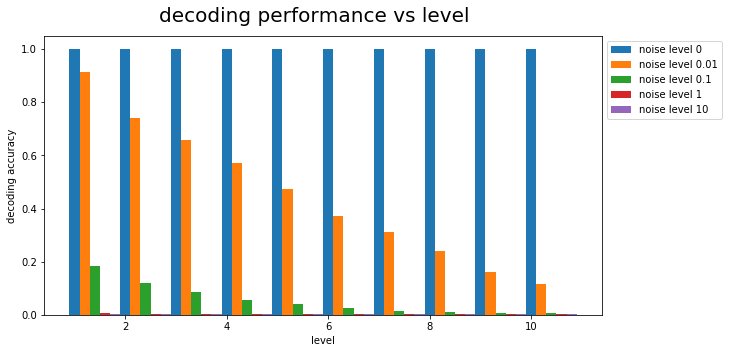

In [8]:
import matplotlib.pyplot as plt
noise_level = [0.01,0.1,1,10]
noise_num = len(noise_level)
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("decoding performance vs level",fontsize=20)
a1.set_ylabel("decoding accuracy")

a1.bar(np.arange(1,11),[1]*10,0.2,color='C0',alpha=1,linestyle='-', label="noise level 0")
for v in range(noise_num): 
    a1.bar(np.arange(1,11)+(v+1)*0.2,decoding_accuracy[v],0.2,color='C'+str(v+1),alpha=1,linestyle='-', label="noise level "+str(noise_level[v]))
    
a1.set_xlabel("level")
a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()

In [1]:
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../'))
from timecorr.timecorr import levelup, timepoint_decoder
from math import log

sliding_window_length = 51
block_length = 1
covariance_num = 300
noise_level = [0,0.01,0.1,1,10]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
level_num = 10
subject_num = 6
activation_num = 5

activations = [[np.random.normal(0,1,[activation_num, time_len]) for i in range(subject_num)] for j in range(noise_num)]
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=[(activations_temp+np.random.normal(0,noise_level[i],[activation_num, time_len])).T for s in range(subject_num)]

# decoding_accuracy = np.zeros([noise_num, level_num])

for i in range(repetitions):
    for l in range(level_num):
        for n in range(noise_num):
            if l>0:
                activations[n] = levelup(activations[n],"within")
            results = timepoint_decoder(activations[n],nfolds=10)
            decoding_accuracy[n,l]+=results
decoding_accuracy/=repetitions


In [ ]:
print(decoding_accuracy)

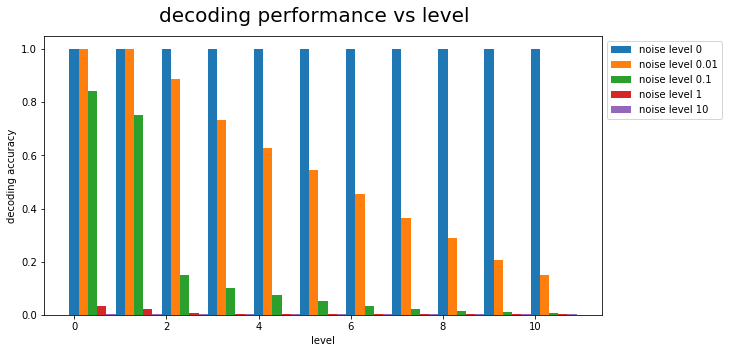

In [1]:
import matplotlib.pyplot as plt
import numpy as np
decoding_accuracy=[[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.],[0.99948889,0.99994444,0.88808889,0.73162222,0.62945556,0.54507778
,0.45373333,0.36276667,0.28862222,0.20704444,0.14895556],[0.8422,0.75302222,0.15155556,0.1003,0.07525556,0.05063333
,0.03266667,0.02181111,0.01387778,0.0093,0.00722222],[0.03284444,0.0216,0.00531111,0.00348889,0.00403333,0.00303333
,0.00362222,0.0036,0.00317778,0.00318889,0.00295556],[0.00361111,0.00332222,0.00311111,0.00348889,0.00325556,0.0033
,0.00318889,0.00358889,0.00335556,0.003,0.00332222]]
noise_level = [0,0.01,0.1,1,10]
noise_num = len(noise_level)
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("decoding performance vs level",fontsize=20)
a1.set_ylabel("decoding accuracy")

for v in range(noise_num): 
    a1.bar(np.arange(0,11)+v*0.2,decoding_accuracy[v],0.2,color='C'+str(v),alpha=1,linestyle='-', label="noise level "+str(noise_level[v]))
    
a1.set_xlabel("level")
a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()

In [16]:
decoding_accuracy = np.zeros(noise_num)
for i in range(100):
    cholesky_ramp_correlation_data()
    for n in range(noise_num):
        results = decoding_analysis(activations[n])
        decoding_accuracy[n]+=results
decoding_accuracy/=repetitions
print(decoding_accuracy)


NameError: name 'decoding_analysis' is not defined